## Challenge 4 – Stan Weinstein Strategy

In this challenge, we implemented the Stan Weinstein strategy — a classic trend-following system based on price structure, volume, and relative strength. The goal was to code this strategy in Python, apply it to a single stock, and then expand it to a portfolio of 20 stocks.

##  Steps:
1. **Watch the Stan Weinstein Strategy** on the [QuantProgram YouTube channel](https://www.youtube.com/@QuantProgram) to understand the rules.
2. **Create the strategy in Python** using your newly acquired skills (price data, moving averages, trend conditions).
3. **Backtest it** over a custom time range and evaluate its performance compared to Buy & Hold.

##  Key Concepts
 
- **30-Week Moving Average (SMA)**: Trend filter — long entries only when price is above the 30-week SMA.
- **Volume Spike**: Confirm breakout strength with volume above a 5-week average.
- **Relative Strength (RS)**: Compare to SPY — only enter if outperforming over the past 50 weeks.
- **52-Week High Breakout**: Entry allowed only when price breaks a new high.

##  Single Stock Backtest
- Strategy applied to Microsoft (MSFT) from 2015 to 2025.
- Weekly data used for all calculations and logic.
- Entry and exit rules applied sequentially.
- Strategy returns compared with Buy & Hold.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


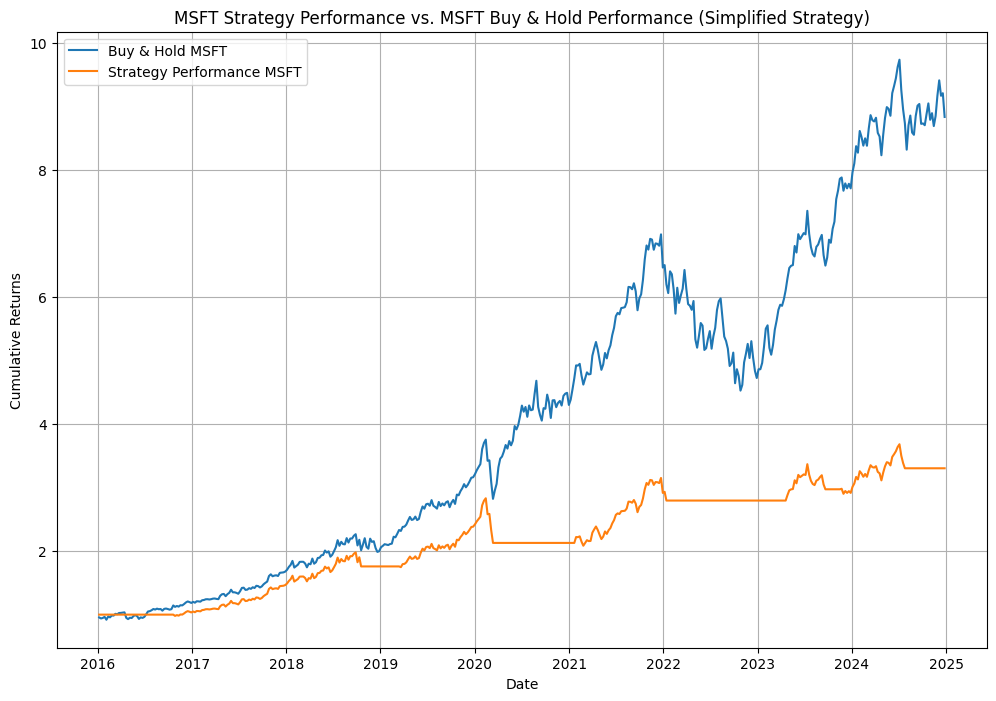


📊 Performance Metrics:
Total Trades Taken: 34
Hit Rate (Winning Trades): 61.89%
Cumulative Return (Strategy): 3.31
Cumulative Return (Buy & Hold): 8.84
Annualized Return (Strategy): 14.18%
Annualized Return (Buy & Hold): 27.33%
Annualized Volatility (Strategy): 14.57%
Annualized Volatility (Buy & Hold): 21.96%
Sharpe Ratio (Strategy): 0.97
Sharpe Ratio (Buy & Hold): 1.24
Max Drawdown (Strategy): -26.38%
Max Drawdown (Buy & Hold): -35.21%


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Global/Strategy Parameters ---
TICKER = 'MSFT'
BENCHMARK = 'SPY'
START_DATE = '2015-01-01'
END_DATE = '2025-01-01'

SMA_PERIOD = 30 # Weinstein's preferred intermediate-term MA period
VOLUME_SMA_PERIOD = 5 
VOLUME_SPIKE_MULTIPLIER = 1.1 
RS_LOOKBACK_WEEKS = 50 # Lookback for relative strength calculation
FIFTY_TWO_WEEK_HIGH_PERIOD = 52 # Period for calculating 52-week high
# -----------------------------------

def get_data():
    df_stock = yf.download(TICKER, START_DATE, END_DATE, interval="1wk",auto_adjust=True)
    df_bench = yf.download(BENCHMARK, START_DATE, END_DATE, interval="1wk",auto_adjust=True)

    df_stock.columns = [col[0] if isinstance(col, tuple) else col for col in df_stock.columns]
    df_bench.columns = [col[0] if isinstance(col, tuple) else col for col in df_bench.columns]

    df_stock_subset = df_stock[['Close', 'Volume','High']].copy()
    df_bench_close = df_bench['Close'].copy()
    df_bench_close = df_bench_close.rename('Close_SPY')

    df = df_stock_subset.join(df_bench_close, how='inner')

    df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['returnsSPY'] = np.log(df['Close_SPY'] / df['Close_SPY'].shift(1))
    df['SMA30'] = df['Close'].rolling(window=SMA_PERIOD, min_periods=SMA_PERIOD).mean()
    df['VolSMA'] = df['Volume'].rolling(window=VOLUME_SMA_PERIOD, min_periods=VOLUME_SMA_PERIOD).mean()

    # --- RS Calculation (50-week cumulative performance based) ---
    df['cumulative_stock_returns'] = (1 + df['returns']).cumprod()
    df['cumulative_SPY_returns'] = (1 + df['returnsSPY']).cumprod()

    df['stock_perf_50w'] = df['cumulative_stock_returns'] / df['cumulative_stock_returns'].shift(RS_LOOKBACK_WEEKS)
    df['SPY_perf_50w'] = df['cumulative_SPY_returns'] / df['cumulative_SPY_returns'].shift(RS_LOOKBACK_WEEKS)
    df['RS'] = df['stock_perf_50w'] / df['SPY_perf_50w'] # RS > 1 means outperformance

    df['High_52_Week'] = df['High'].rolling(window=FIFTY_TWO_WEEK_HIGH_PERIOD, min_periods=FIFTY_TWO_WEEK_HIGH_PERIOD).max().shift(1)

    return df.dropna()

def add_strategy(df):
    # --- 1. Calculate Entry Signal ---
    df['entry_signal'] = np.where(
        (df['Close'] > df['SMA30']) &                               # Price above SMA30
        (df['Volume'] > (VOLUME_SPIKE_MULTIPLIER * df['VolSMA'])) & # Volume spike confirmation
        (df['RS'] > 1) & # Relative Strength: Stock outperforming benchmark (RS > 1 for ratio)
        (df['Close'] > df['High_52_Week']),                                             
        1, 0
    )

    # Only exit when Close price drops below SMA30
    df['exit_close_below_sma'] = (df['Close'] < df['SMA30']).astype(int)

    # --- 3. Determine Final Position based on Entry and Exit Rules Sequentially ---
    df['position'] = 0 # Initialize position column

    current_position = 0
    for i in range(1, len(df)):
        # Check for Exit Conditions FIRST if currently in a trade
        # Only using 'exit_close_below_sma' now
        if current_position == 1 and (
            df['exit_close_below_sma'].iloc[i] == 1
        ):
            current_position = 0 # Exit the trade
        # Else, if currently out of a trade, check for Entry Conditions
        elif current_position == 0 and df['entry_signal'].iloc[i] == 1:
            current_position = 1 # Enter the trade
        # Otherwise, maintain current_position

        df.loc[df.index[i], 'position'] = current_position

    df.iloc[0, df.columns.get_loc('position')] = 0 # Ensure first row has no position

    # --- 4. Calculate Strategy Returns ---
    df['strategy'] = df['returns'] * df['position'].shift(1)

    df.dropna(inplace=True)
    return df

def test_strategy(df):
    if df.empty:
        print("DataFrame is empty after strategy application and dropping NaNs. Cannot plot results.")
        return

    df['returnsbh'] = df['returns'].cumsum().apply(np.exp)
    df['returns_strategy'] = df['strategy'].cumsum().apply(np.exp)

    plt.figure(figsize=(12, 8))
    plt.plot(df.index, df['returnsbh'], label=f'Buy & Hold {TICKER}')
    plt.plot(df.index, df['returns_strategy'], label=f'Strategy Performance {TICKER}')
    plt.title(f'{TICKER} Strategy Performance vs. {TICKER} Buy & Hold Performance (Simplified Strategy)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- METRICS ---
    strategy_returns = df['strategy'].dropna()
    bh_returns = df['returns'].dropna()

    weeks_per_year = 52

    # Cumulative return
    cum_strategy = np.exp(strategy_returns.sum())
    cum_bh = np.exp(bh_returns.sum())

    # Annualized return
    ann_ret_strategy = np.exp(strategy_returns.mean() * weeks_per_year) - 1
    ann_ret_bh = np.exp(bh_returns.mean() * weeks_per_year) - 1

    # Annualized volatility
    ann_vol_strategy = strategy_returns.std() * np.sqrt(weeks_per_year)
    ann_vol_bh = bh_returns.std() * np.sqrt(weeks_per_year)

    # Sharpe ratio (assuming risk-free rate = 0)
    sharpe_strategy = ann_ret_strategy / ann_vol_strategy
    sharpe_bh = ann_ret_bh / ann_vol_bh

    # Max drawdown
    cum_returns_strategy = strategy_returns.cumsum().apply(np.exp)
    peak = cum_returns_strategy.cummax()
    drawdown = (cum_returns_strategy - peak) / peak
    max_dd_strategy = drawdown.min()
    # Max drawdown for Buy & Hold
    cum_returns_bh = bh_returns.cumsum().apply(np.exp)
    peak_bh = cum_returns_bh.cummax()
    drawdown_bh = (cum_returns_bh - peak_bh) / peak_bh
    max_dd_bh = drawdown_bh.min()


    num_trades = df['entry_signal'].sum()
    strategy_returns = df['strategy'][df['position'].shift(1) == 1]
    win_rate = (strategy_returns > 0).mean()
    




    print("\n📊 Performance Metrics:")
    print(f"Total Trades Taken: {num_trades}")
    print(f"Hit Rate (Winning Trades): {win_rate:.2%}")
    print(f"Cumulative Return (Strategy): {cum_strategy:.2f}")
    print(f"Cumulative Return (Buy & Hold): {cum_bh:.2f}")
    print(f"Annualized Return (Strategy): {ann_ret_strategy:.2%}")
    print(f"Annualized Return (Buy & Hold): {ann_ret_bh:.2%}")
    print(f"Annualized Volatility (Strategy): {ann_vol_strategy:.2%}")
    print(f"Annualized Volatility (Buy & Hold): {ann_vol_bh:.2%}")
    print(f"Sharpe Ratio (Strategy): {sharpe_strategy:.2f}")
    print(f"Sharpe Ratio (Buy & Hold): {sharpe_bh:.2f}")
    print(f"Max Drawdown (Strategy): {max_dd_strategy:.2%}")
    print(f"Max Drawdown (Buy & Hold): {max_dd_bh:.2%}")

    return df

def main():
    df = get_data()
    df = add_strategy(df)

    if df is None or df.empty:
        print("DataFrame is empty or None after add_strategy. Exiting.")
        return

    df = test_strategy(df)
    

main()

##  Multi-Stock Portfolio Backtest
- Portfolio of 20 large-cap U.S. stocks.
- Backtest engine allowed up to 5 open positions.
- Fixed capital allocation: 20% of portfolio per trade.
- Trades entered only if entry rules are met.
- Strategy returns benchmarked against SPY.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Starting multi-stock backtest for 20 stocks.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


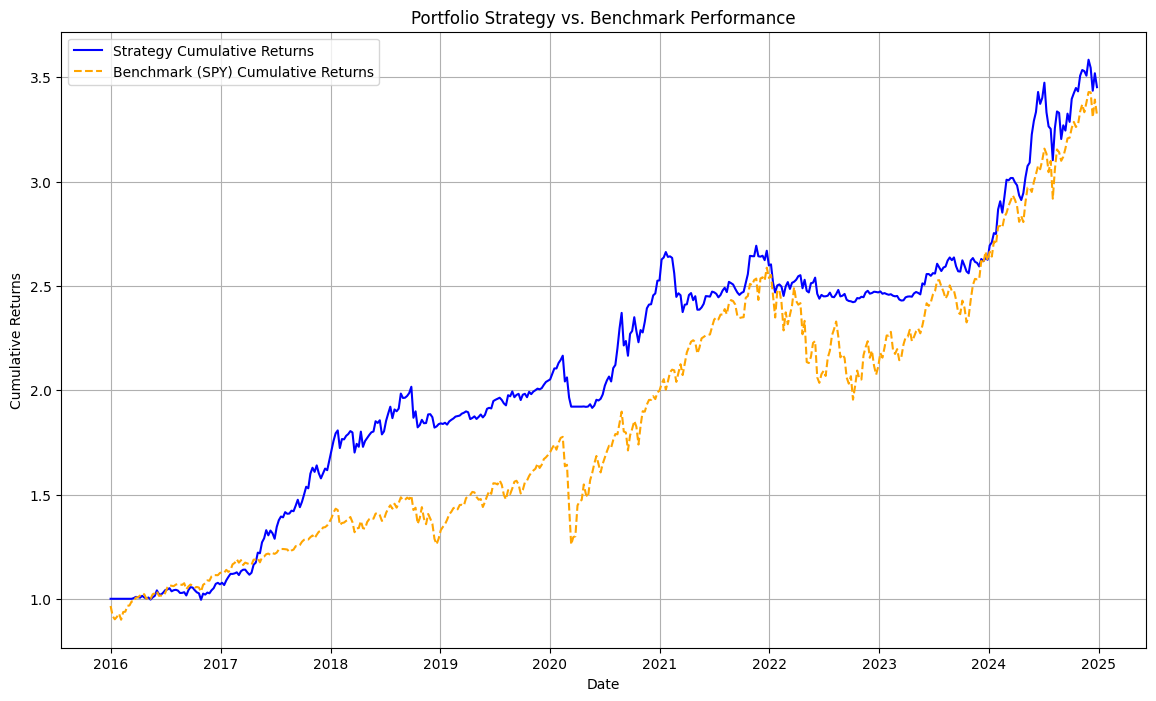


📊 Portfolio Performance Metrics:
Initial Capital: $100,000.00
Final Portfolio Value: $345,312.88
Total Trades Taken: 57
Win Rate: 56.14%
Cumulative Return (Strategy): 245.31%
Cumulative Return (Benchmark): 231.90%
Annualized Return (Strategy): 14.70%
Annualized Return (Benchmark): 14.19%
Annualized Volatility (Strategy): 11.90%
Annualized Volatility (Benchmark): 16.54%
Sharpe Ratio (Strategy): 1.23
Sharpe Ratio (Benchmark): 0.86
Max Drawdown (Strategy): -11.55%
Max Drawdown (Benchmark): -29.07%

Detailed Trade Log (First 10 entries):
        Date   Type Ticker  Shares       Price         Value
0 2016-03-10  Entry     KO     599   33.385185  19997.725960
1 2016-03-17  Entry    UNH     177  112.482719  19909.441338
2 2016-03-17  Entry    JNJ     238   83.987671  19989.065674
3 2016-04-14  Entry      V     262   76.091896  19936.076767
4 2016-05-05  Entry   AMZN     560   35.661499  19970.439453
5 2016-06-30   Exit      V     262   69.566750  18226.488388
6 2016-07-21   Exit     KO     5

In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Global/Strategy Parameters ---
# Now a list of tickers
TICKERS = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'JPM', 'UNH', 'LLY', 'XOM', 'JNJ',
    'V', 'MA', 'TSLA', 'PG', 'KO', 'HD', 'COST', 'WMT', 'CVX', 'MRK'
] # Example 20 large-cap stocks
BENCHMARK = 'SPY'
START_DATE = '2015-01-01'
END_DATE = '2025-01-01'

SMA_PERIOD = 30
VOLUME_SMA_PERIOD = 5
VOLUME_SPIKE_MULTIPLIER = 1.1
RS_LOOKBACK_WEEKS = 50
FIFTY_TWO_WEEK_HIGH_PERIOD = 52

INITIAL_CAPITAL = 100000 # starting capital
MAX_OPEN_POSITIONS = 5 # How many stocks can you hold at once
POSITION_SIZE_PERCENT = 0.20 # Percentage of current capital per trade (e.g., 20% means 5 trades max if using all capital)
# Or a fixed dollar amount: FIXED_POSITION_SIZE = 20000 # Example: $20,000 per trade

# --- Data Collection ---
def get_all_data(tickers, benchmark_ticker, start, end):
    all_data = {}
    for ticker in tickers + [benchmark_ticker]:
        print(f"Downloading {ticker}...")
        df = yf.download(ticker, start, end, interval="1wk", auto_adjust=True)
        if df.empty:
            print(f"Warning: No data for {ticker}. Skipping.")
            continue
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
        all_data[ticker] = df[['Close', 'Volume', 'High']].copy()

    # Align all dataframes by date
    # Start with benchmark data index
    combined_index = all_data[benchmark_ticker].index
    for ticker, df in all_data.items():
        combined_index = combined_index.intersection(df.index)

    # Reindex all dataframes to the common index
    processed_data = {}
    for ticker, df in all_data.items():
        processed_data[ticker] = df.reindex(combined_index).ffill().dropna() # ffill to handle missing dates, then drop any remaining NaNs

    return processed_data

# --- Feature Engineering for a Single Stock (now a helper function) ---
def calculate_features(df_stock, df_benchmark_close, benchmark_ticker_name):
    # Ensure benchmark data is aligned with stock data
    df = df_stock.copy()
    df[benchmark_ticker_name] = df_benchmark_close.reindex(df.index).ffill()

    df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['returns_bench'] = np.log(df[benchmark_ticker_name] / df[benchmark_ticker_name].shift(1))
    df['SMA30'] = df['Close'].rolling(window=SMA_PERIOD, min_periods=SMA_PERIOD).mean()
    df['VolSMA'] = df['Volume'].rolling(window=VOLUME_SMA_PERIOD, min_periods=VOLUME_SMA_PERIOD).mean()

    # Cumulative returns for RS
    df['cumulative_stock_returns'] = (1 + df['returns']).cumprod()
    df['cumulative_bench_returns'] = (1 + df['returns_bench']).cumprod()
    df['stock_perf_lookback'] = df['cumulative_stock_returns'] / df['cumulative_stock_returns'].shift(RS_LOOKBACK_WEEKS)
    df['bench_perf_lookback'] = df['cumulative_bench_returns'] / df['cumulative_bench_returns'].shift(RS_LOOKBACK_WEEKS)
    df['RS'] = df['stock_perf_lookback'] / df['bench_perf_lookback']

    df['High_52_Week'] = df['High'].rolling(window=FIFTY_TWO_WEEK_HIGH_PERIOD, min_periods=FIFTY_TWO_WEEK_HIGH_PERIOD).max().shift(1)

    return df.dropna()

# --- Backtesting Engine ---
def run_backtest(all_processed_data, tickers_to_test, benchmark_ticker_name):
    benchmark_df = all_processed_data[benchmark_ticker_name]
    trading_universe = {}
    for ticker in tickers_to_test:
        if ticker in all_processed_data:
            trading_universe[ticker] = calculate_features(all_processed_data[ticker], benchmark_df['Close'], benchmark_ticker_name)
        else:
            print(f"Skipping {ticker} as data was not available.")

    # Get a common date range for all processed stocks
    common_dates = None
    for ticker_df in trading_universe.values():
        if common_dates is None:
            common_dates = ticker_df.index
        else:
            common_dates = common_dates.intersection(ticker_df.index)

    if common_dates.empty:
        print("No common dates across all stocks after feature calculation. Cannot run backtest.")
        return pd.DataFrame()

    common_dates = common_dates.sort_values() # Ensure dates are sorted

    portfolio_history = []
    portfolio_value = INITIAL_CAPITAL
    cash = INITIAL_CAPITAL
    positions = {} # {ticker: shares_held}
    trade_log = [] # To log entries and exits

    for current_date in common_dates:
        current_portfolio_value = cash
        # Update current portfolio value based on current prices
        for ticker, shares in positions.items():
            if ticker in trading_universe and current_date in trading_universe[ticker].index:
                current_portfolio_value += shares * trading_universe[ticker].loc[current_date, 'Close']

        # Log daily portfolio value
        portfolio_history.append({'Date': current_date, 'Portfolio_Value': current_portfolio_value})

        # --- Evaluate Exit Conditions First ---
        exits_this_bar = []
        for ticker, shares in list(positions.items()): # Iterate over a copy as we might modify positions
            if ticker in trading_universe and current_date in trading_universe[ticker].index:
                stock_data_at_date = trading_universe[ticker].loc[current_date]

                # Exit condition: Close drops below SMA30
                if stock_data_at_date['Close'] < stock_data_at_date['SMA30']:
                    exit_price = stock_data_at_date['Close']
                    cash += shares * exit_price
                    trade_log.append({
                        'Date': current_date,
                        'Type': 'Exit',
                        'Ticker': ticker,
                        'Shares': shares,
                        'Price': exit_price,
                        'Value': shares * exit_price
                    })
                    exits_this_bar.append(ticker) # Mark for removal

        for ticker in exits_this_bar:
            del positions[ticker]

        # --- Evaluate Entry Conditions ---
        entry_candidates = []
        for ticker, df_stock in trading_universe.items():
            if ticker not in positions and current_date in df_stock.index: # Not currently holding this stock
                stock_data_at_date = df_stock.loc[current_date]

                # Entry conditions:
                cond_price_above_sma = (stock_data_at_date['Close'] > stock_data_at_date['SMA30'])
                cond_volume_spike = (stock_data_at_date['Volume'] > (VOLUME_SPIKE_MULTIPLIER * stock_data_at_date['VolSMA']))
                cond_rs_strong = (stock_data_at_date['RS'] > 1)
                cond_52_week_high = (stock_data_at_date['Close'] > stock_data_at_date['High_52_Week'])

                if cond_price_above_sma and cond_volume_spike and cond_rs_strong and cond_52_week_high:
                    entry_candidates.append({'Ticker': ticker, 'Price': stock_data_at_date['Close']})

        # Sort candidates (e.g., by RS, or randomly, or by magnitude of breakout)
        # For simplicity, just take the first ones that fit
        for candidate in entry_candidates:
            if len(positions) < MAX_OPEN_POSITIONS:
                # Calculate position size based on current cash
                # Ensure we don't try to buy with negative cash or tiny amounts
                trade_value = portfolio_value * POSITION_SIZE_PERCENT
                if cash >= trade_value and candidate['Price'] > 0:
                    shares_to_buy = int(trade_value / candidate['Price'])
                    if shares_to_buy > 0:
                        cost = shares_to_buy * candidate['Price']
                        cash -= cost
                        positions[candidate['Ticker']] = shares_to_buy
                        trade_log.append({
                            'Date': current_date,
                            'Type': 'Entry',
                            'Ticker': candidate['Ticker'],
                            'Shares': shares_to_buy,
                            'Price': candidate['Price'],
                            'Value': cost
                        })

    # --- Finalize Portfolio Value ---
    final_portfolio_value = cash
    for ticker, shares in positions.items():
        # Use the last available close price for stocks still held
        if ticker in trading_universe and not trading_universe[ticker].empty:
            final_portfolio_value += shares * trading_universe[ticker].iloc[-1]['Close'] # Using last price of each df

    portfolio_history_df = pd.DataFrame(portfolio_history).set_index('Date')
    portfolio_history_df['Strategy_Returns'] = portfolio_history_df['Portfolio_Value'].pct_change().fillna(0)

    # Calculate Benchmark Returns
    benchmark_returns = benchmark_df['Close'].pct_change().fillna(0)
    # Align benchmark returns to strategy dates
    portfolio_history_df['Benchmark_Returns'] = benchmark_returns.reindex(portfolio_history_df.index).fillna(0)

    return portfolio_history_df, pd.DataFrame(trade_log)


# --- Performance Analysis & Plotting ---
def analyze_results(portfolio_df, trade_log_df):
    if portfolio_df.empty:
        print("No portfolio history to analyze.")
        return

    # Calculate cumulative returns
    portfolio_df['Cumulative_Strategy_Returns'] = (1 + portfolio_df['Strategy_Returns']).cumprod()
    portfolio_df['Cumulative_Benchmark_Returns'] = (1 + portfolio_df['Benchmark_Returns']).cumprod()

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(portfolio_df.index, portfolio_df['Cumulative_Strategy_Returns'], label='Strategy Cumulative Returns', color='blue')
    plt.plot(portfolio_df.index, portfolio_df['Cumulative_Benchmark_Returns'], label=f'Benchmark ({BENCHMARK}) Cumulative Returns', color='orange', linestyle='--')
    plt.title('Portfolio Strategy vs. Benchmark Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Metrics
    weeks_per_year = 52

    # Annualized return
    # Use log returns for more accurate annualization
    log_strategy_returns = np.log(1 + portfolio_df['Strategy_Returns']).dropna()
    log_benchmark_returns = np.log(1 + portfolio_df['Benchmark_Returns']).dropna()

    ann_ret_strategy = (np.exp(log_strategy_returns.mean() * weeks_per_year) - 1) * 100
    ann_ret_benchmark = (np.exp(log_benchmark_returns.mean() * weeks_per_year) - 1) * 100

    # Annualized volatility
    ann_vol_strategy = log_strategy_returns.std() * np.sqrt(weeks_per_year) * 100
    ann_vol_benchmark = log_benchmark_returns.std() * np.sqrt(weeks_per_year) * 100

    # Sharpe Ratio (assuming risk-free rate = 0 for simplicity)
    sharpe_strategy = ann_ret_strategy / ann_vol_strategy if ann_vol_strategy > 0 else np.nan
    sharpe_benchmark = ann_ret_benchmark / ann_vol_benchmark if ann_vol_benchmark > 0 else np.nan

    # Max Drawdown
    peak_strategy = portfolio_df['Cumulative_Strategy_Returns'].cummax()
    drawdown_strategy = (portfolio_df['Cumulative_Strategy_Returns'] - peak_strategy) / peak_strategy
    max_dd_strategy = drawdown_strategy.min() * 100

    peak_benchmark = portfolio_df['Cumulative_Benchmark_Returns'].cummax()
    drawdown_benchmark = (portfolio_df['Cumulative_Benchmark_Returns'] - peak_benchmark) / peak_benchmark
    max_dd_benchmark = drawdown_benchmark.min() * 100


    total_trades = len(trade_log_df[trade_log_df['Type'] == 'Entry'])
    winning_trades = 0
    losing_trades = 0
    trade_profits = []

    # Calculate profit/loss per trade
    current_entry_price = {}
    for _, row in trade_log_df.iterrows():
        if row['Type'] == 'Entry':
            current_entry_price[row['Ticker']] = row['Price']
        elif row['Type'] == 'Exit' and row['Ticker'] in current_entry_price:
            entry_price = current_entry_price.pop(row['Ticker'])
            pnl = (row['Price'] - entry_price) * row['Shares']
            trade_profits.append(pnl)
            if pnl > 0:
                winning_trades += 1
            else:
                losing_trades += 1

    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0


    print("\n📊 Portfolio Performance Metrics:")
    print(f"Initial Capital: ${INITIAL_CAPITAL:,.2f}")
    print(f"Final Portfolio Value: ${portfolio_df['Portfolio_Value'].iloc[-1]:,.2f}")
    print(f"Total Trades Taken: {total_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Cumulative Return (Strategy): {portfolio_df['Cumulative_Strategy_Returns'].iloc[-1] - 1:.2%}")
    print(f"Cumulative Return (Benchmark): {portfolio_df['Cumulative_Benchmark_Returns'].iloc[-1] - 1:.2%}")
    print(f"Annualized Return (Strategy): {ann_ret_strategy:.2f}%")
    print(f"Annualized Return (Benchmark): {ann_ret_benchmark:.2f}%")
    print(f"Annualized Volatility (Strategy): {ann_vol_strategy:.2f}%")
    print(f"Annualized Volatility (Benchmark): {ann_vol_benchmark:.2f}%")
    print(f"Sharpe Ratio (Strategy): {sharpe_strategy:.2f}")
    print(f"Sharpe Ratio (Benchmark): {sharpe_benchmark:.2f}")
    print(f"Max Drawdown (Strategy): {max_dd_strategy:.2f}%")
    print(f"Max Drawdown (Benchmark): {max_dd_benchmark:.2f}%")

    print("\nDetailed Trade Log (First 10 entries):")
    print(trade_log_df.head(10).to_string())
    print("\nDetailed Trade Log (Last 10 entries):")
    print(trade_log_df.tail(10).to_string())


def main():
    print(f"Starting multi-stock backtest for {len(TICKERS)} stocks.")
    all_raw_data = get_all_data(TICKERS, BENCHMARK, START_DATE, END_DATE)

    if not all_raw_data:
        print("No data retrieved. Exiting.")
        return

    portfolio_history_df, trade_log_df = run_backtest(all_raw_data, TICKERS, BENCHMARK)

    if portfolio_history_df.empty:
        print("Backtest resulted in an empty portfolio history. Check data and strategy logic.")
        return

    analyze_results(portfolio_history_df, trade_log_df)

if __name__ == "__main__":
    main()